# Project 2：NASA Data Acquisation, Visualization, and Analysis

In [198]:
# The code makes sure that once there is change in the 'src/' folder, the 
# change will be automatically reloaded in the notebook.
%reload_ext autoreload
%autoreload 2
%aimport src

### Task 1: Understanding the NASA API and Data Collection

- Register for a NASA API key and understand the different types of data that the API provides.
- Run the Python script below to fetch data about **Near Earth Objects (NEOs)** from the NASA API for a years data.
- Extract and understand the different pieces of data provided for each NEO.

In [199]:
import requests
import time
from datetime import datetime, timedelta
from getpass import getpass
import json
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# Set your NASA API KEY, this step asks you to enter your API KEY.
# (The input box may be float in the top on your editor.)

api_key = getpass()

print(api_key)
#1yBDwWKaSn67OnwDtagWVRciQLajbITVUXztCnll
#rlLMa02AyLSCwB4ingUxn8WiN88FErbPtBC1DsA7

# New API key
#5moAl3aXJFGab03t4Rwyvnsb9UKRUSq5Tpu2aZYm

5moAl3aXJFGab03t4Rwyvnsb9UKRUSq5Tpu2aZYm


In [200]:
# Set the start and end dates for the data you want to fetch
start_date = datetime.strptime('2022-01-01', '%Y-%m-%d')
end_date = start_date + timedelta(days=365)  # 1 year later

# Initialize a list to store the data
data = []

# Fetch data from the NASA API 7 days at a time
# The introduction of the API is on https://api.nasa.gov, under "Browse APIs" -> "Asteroids NeoWs"
# You can look into the example query in the link below to see what the data look like:
# https://api.nasa.gov/neo/rest/v1/feed?start_date=2015-09-07&end_date=2015-09-08&api_key=DEMO_KEY
current_date = start_date
while current_date < end_date:
    next_date = min(current_date + timedelta(days=7), end_date)
    response = requests.get(f'https://api.nasa.gov/neo/rest/v1/feed?start_date={current_date.strftime("%Y-%m-%d")}&end_date={next_date.strftime("%Y-%m-%d")}&api_key={api_key}')
    data.append(response.json())
    current_date = next_date
    time.sleep(1)  # To avoid hitting the rate limit

# Now 'data' contains the NEO data for the 1-year period


In [201]:
# Check the date coverage of your data.
dates_contained_in_data = []
for d in data:
    dates_contained_in_data += list(d['near_earth_objects'].keys())

#print(sorted(dates_contained_in_data))

In [202]:
from src.utils import get_a_random_chunk_property

#get_a_random_chunk_property(data)

For the remaining tasks, you have to organize the data as pd.DataFrame so as to suit the specific need in each task. This part may require a considerably amount of efforts, which is normal in data science and analytics works.

### Task 2: Data Analysis

- Calculate the average size of the NEOs for each day.
- Determine the proportion of NEOs that are potentially hazardous.
- Find the NEO with the closest approach distance for each day.
- Use statistical methods to analyze the data. For example, calculate the mean, median, mode, and standard deviation of the NEO sizes. Determine if the size of a NEO is correlated with whether it is potentially hazardous.

In [203]:
# Sort the data so 2022-01-01 is first
dates_contained_in_data = sorted(dates_contained_in_data)



#Define a new empyt dataframe
df_NEO = pd.DataFrame(index=dates_contained_in_data)
df_NEO_dis = pd.DataFrame(index=dates_contained_in_data)
df_NEO_haz = pd.DataFrame(index=dates_contained_in_data)

#Loop over all days to get data from each NEO
index = 0
for date in dates_contained_in_data:
    # Finding the week number 
    week = math.floor(index/8)

    # Get all data form the day
    data_list = data[week]["near_earth_objects"][date]
    
    #Loop over NEO
    for i in range(0, len(data_list)):
        
        # Get size and distance
        size = data_list[i]['absolute_magnitude_h']
        dis = data_list[i]['close_approach_data'][0]['miss_distance']['kilometers']
        hazardous = data_list[i]['is_potentially_hazardous_asteroid']
        
        # Save to dataframe
        df_NEO.loc[date, i]=size
        df_NEO_dis.loc[date, i]=dis
        df_NEO_haz.loc[date, i]=hazardous

    #Update the index
    index += 1


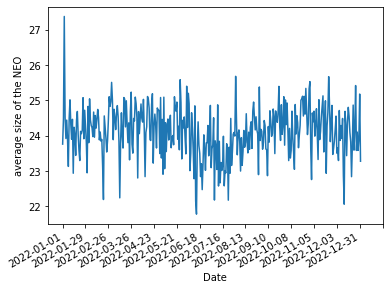

In [252]:
#Plot average size of the NEO's

df_NEO_avg = df_NEO.mean(axis=1)
#df_NEO_avg.head()


plt.plot(df_NEO.index, df_NEO_avg)
plt.xticks(rotation=30, ha='right', ticks=np.arange(0,418,28))
plt.xlabel('Date')
plt.ylabel('average size of the NEO')
plt.show()



(418, 38)


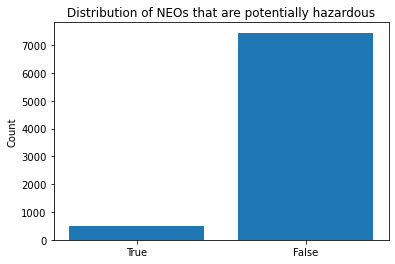

6.3765564079989945


In [256]:
#Determine the proportion of NEOs that are potentially hazardous.
haz = []

shape = df_NEO_haz.shape

print(shape)

for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if pd.isna(df_NEO_haz.iloc[i,j]) == True:
            break
        else:
            haz.append(df_NEO_haz.iloc[i,j])



import matplotlib.pyplot as plt


# Count the occurrences of True and False
true_count = haz.count(True)
false_count = haz.count(False)

# Plotting the distribution
labels = ['True', 'False']
counts = [true_count, false_count]

plt.bar(labels, counts)
#plt.xlabel('Values')
plt.ylabel('Count')
plt.title('Distribution of NEOs that are potentially hazardous')
plt.show()


print((true_count/(true_count+false_count))*100)


6 % of the NEO's are potentially hazardous.

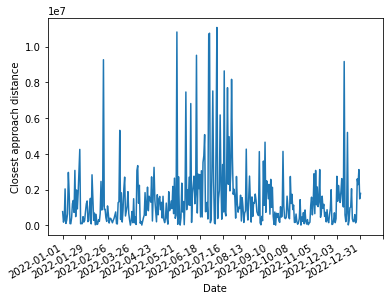

In [259]:
#NEO with the closest approach distance for each day


df_NEO_dis = df_NEO_dis.astype('float')
df_NEO_dis_min = df_NEO_dis.min(axis=1)
df_NEO_dis.min(axis=1).head()


plt.plot(df_NEO_dis.index, df_NEO_dis_min)
plt.xticks(rotation=30, ha='right', ticks=np.arange(0,418,28))
plt.xlabel('Date')
plt.ylabel('Closest approach distance')
plt.show()



In [262]:
#- Use statistical methods to analyze the data. For example, calculate the mean, median, mode, and standard deviation of the NEO sizes. Determine if the size of a NEO is correlated with whether it is potentially hazardous.

from scipy import stats

# Get all size values
values_size = []
for i in range(0,df_NEO.shape[0]):
    for j in range(0,df_NEO.shape[1]):
        if pd.isna(df_NEO.iloc[i,j]) == True:
            break
        else:
            values_size.append(df_NEO.iloc[i,j])


stats.describe(values_size)

DescribeResult(nobs=7951, minmax=(14.68, 32.95), mean=24.157607470758393, variance=7.461167343637262, skewness=-0.34689661620089246, kurtosis=-0.16533238537988737)

### Task 3: Data Visualization Part A

- Create a line plot of the number of NEOs per week.
- Create a histogram of the distribution of NEO sizes.
- Create a bar plot of the average NEO size per week.
- Use a library like Seaborn to create more complex visualizations, such as a box plot of the NEO sizes or a heat map of the number of NEOs per week. **Be creative**!

<AxesSubplot:>

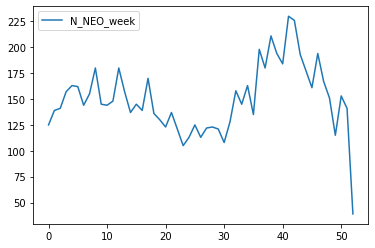

In [208]:
# Line plot of the number of NEOs per week.


#Define a new empyt dataframe
df_N_NEO = pd.DataFrame(columns=['N_NEO_week'],index = list(range(0,53)))

#Loop over all days to get data from each NEO
index = 0
for date in dates_contained_in_data:
    # Finding the week number 
    week = math.floor(index/8)

    # Get all data form the day
    data_list = data[week]["near_earth_objects"][date]
    
    number_of_NEO = len(data_list)

    if pd.isna(df_N_NEO.loc[week, 'N_NEO_week']) == True:
        df_N_NEO.loc[week, 'N_NEO_week'] = number_of_NEO
    else:
        df_N_NEO.loc[week, 'N_NEO_week'] = df_N_NEO.loc[week, 'N_NEO_week'] + number_of_NEO

    #Update the index
    index += 1



df_N_NEO.plot()

The number of NEOs decrease over the sommer.

24.157607470758393


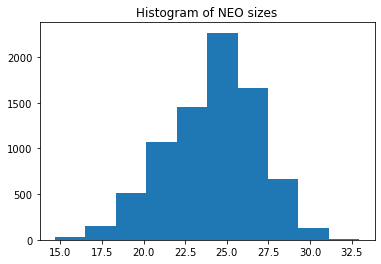

In [265]:
#Histogram of NEO sizes




print(np.mean(values_size))
plt.hist(values_size)
plt.title('Histogram of NEO sizes')
plt.show()



The histogram looks like a skewed normal distribution. The average size of the NEO's is 24.2.

<AxesSubplot:>

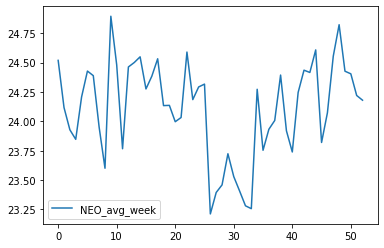

In [210]:
#Bar plot of the average NEO size per week

df_NEO_avg_week = pd.DataFrame(columns=['NEO_avg_week'],index = list(range(0,53)))
    

for i in range(0,53):
    X = df_NEO.iloc[0+i*7:7+i*7,:].to_numpy()
    mean = np.nanmean(X)
    df_NEO_avg_week.loc[i, 'NEO_avg_week'] = mean


#df_NEO_avg_week.head()


df_NEO_avg_week.plot()




In [211]:
#Be creative 



### Task 4: Data Visualization Part B

- Create a pie chart of the proportion of hazardous vs non-hazardous NEOs.
- Create a scatter plot of the correlation between NEO size and close approach distance.
- Customize the appearance of your plots (e.g., colors, labels, titles).
- Create interactive visualizations using a library like Plotly. For example, create an interactive scatter plot where you can hover over each point to see more information about the NEO. **Be creative!**

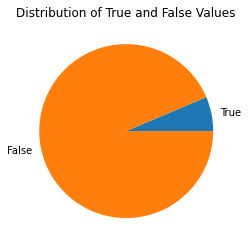

In [212]:
#  Pie chart of the proportion of hazardous vs non-hazardous NEOs.


# Count the occurrences of True and False
true_count = haz.count(True)
false_count = haz.count(False)

# Plotting the distribution
labels = ['True', 'False']
counts = [true_count, false_count]

plt.pie(counts, labels = labels)
plt.title('Distribution of True and False Values')
plt.show() 

(418, 38)


<AxesSubplot:>

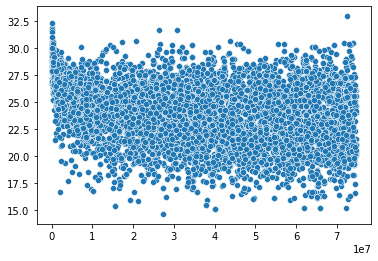

In [219]:
# Scatter plot of the correlation between NEO size and close approach distance.

import seaborn

values_dis = []


shape = df_NEO_dis.shape

print(shape)

for i in range(0,shape[0]):
    for j in range(0,shape[1]):
        if pd.isna(df_NEO_dis.iloc[i,j]) == True:
            break
        else:
            values_dis.append(df_NEO_dis.iloc[i,j])





seaborn.scatterplot(y=values, x=values_dis)




In [214]:
# Interactive visualizations





### Task 5: Interpretation of Results

- Interpret the results of your data visualization in part A and B. 
- What insights can you gain about NEOs from your results? Summarizing your findings.
- Use your findings to make predictions or recommendations. For example, if you found that larger NEOs are more likely to be potentially hazardous, you could recommend that more resources be allocated to tracking large NEOs. **Be creative!**
- Identify, understand, and explain one scientific paper, on a clustering or classification method of relevance that could help Task 5. You don't have to implement it, you just need to justify in this notebook why the method in the scientific paper could contribute in analysis or interpretation of the results.

In [215]:
# Write your code

### Task 6: Presentation and Documentation

- Make this project as part of your presentation, **using beamer in LaTeX**. 
- This should include an overview of your work, the results of your data analysis, and the insights you gained from your results.